# Teaching Quantum Models with Pennylane

The aim of this tutorial is to introduce the reader to the concept of quantum (machine learning) models learning. We will do so using the [Xanadu's](https://www.xanadu.ai/) QML library called [PennyLane](https://pennylane.ai/). By the end of the tutorial we will know how to design a variational quantum circuit (VQC) and how to teach it to perform  binary classification.


## Resources

Obviously, our main resource will be the [PennyLane documentaiton](https://docs.pennylane.ai/en/stable/).

## Requirements

Below is the list of the most important libraries (and their versions) used in this tutorial.
`python==3.11`
`PennyLane==0.29.1`
`scikit-learn==1.2.2`
`matplotlib==3.7.1`
Aside from the library requirements, throughout the tutorial we'll assume that the reader have some **basic knowledge of quantum computing** (so I won't be defining terms like e.g. **qubit** or **Dirac's notation**). For the tutorial purposes, we will also assume that the reader has seen the following PennyLane tutorials
- [Basic tutorial: qubit rotation](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html)
- [Quantum embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html)
- [https://pennylane.ai/qml/demos/tutorial_variational_classifier.html](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)

## Task description

Our task is to prepare a (quantum) binary classifier that will be able to properly classify the `moons` dataset. Let's see what we're dealing with.

In [3]:
from typing import List, Sequence
from sklearn.datasets import make_moons
from pennylane import numpy as np
from numpy.random import RandomState

First, we prepare the data. The `make_moons` method of `sklearn.datasets` requires a number of arguments from us (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)). Naturally we want to specify the number of samples we want our dataset to have.

In [4]:
n_samples: int = 100

If you're confused by the above notation, please see [how python supports type hinting](https://docs.python.org/3/library/typing.html). For our needs, all you need to know is that the structure `<variable>: <class>` hints that the `<variable>` should be of class `<class>`.

In [5]:
random_state: RandomState = RandomState(42)  # Ensures that the generated datasets are the same everytime.
noise: float = 0.1  # Introduces the noise to generated circuits.

X: np.ndarray  # 2d of floats
y: np.ndarray  # of ints

X, y = make_moons(
    n_samples=n_samples,
    shuffle=True,
    noise=noise,
    random_state=random_state
)

We can now see how our dataset looks like. We will do so using `matplotlib`.

In [6]:
import matplotlib.pyplot as plt

Now we visualize the dataset.

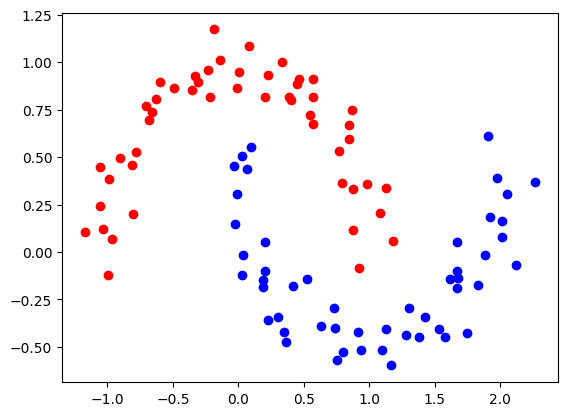

In [7]:
# Separate the points.
first_plot_points: List[Sequence[float]] = [X[i] for i in range(len(X)) if y[i] == 0]
second_plot_points: List[Sequence[float]] = [X[i] for i in range(len(X)) if y[i] == 1]

# Separate the dimensions.
first_plot_x: List[float] = [pt[0] for pt in first_plot_points]
first_plot_y: List[float] = [pt[1] for pt in first_plot_points]

second_plot_x: List[float] = [pt[0] for pt in second_plot_points]
second_plot_y: List[float] = [pt[1] for pt in second_plot_points]

# Plot the results.
colors: List[str] = ["red", "blue"]  # To distinguish the classes.

plt.plot(first_plot_x, first_plot_y, color=colors[0], linewidth=0, marker="o")
plt.plot(second_plot_x, second_plot_y, color=colors[1], linewidth=0, marker="o")
plt.show()

I think we can agree that this dataset seems simple. It is, however, **not linearly-separable**, so it's not that trivial. This will make the classification a little bit more challenging. We're now ready to start preparing the classifier.

## Quantum Neural Networks (or VQCs)

A Quantum Neural Network (QNN) is a combination of two concepts -- quantum computing (QC) and artificial neural networks (ANN). Lately, the name QNN has been used to describe VQC (see [here](https://pennylane.ai/qml/glossary/quantum_neural_network.html#id1)).

The VQC consists of several building blocks -- __wires__, __gates__ and __measurements__. An example of quantum circuit is presented on the figure below (source [PennyLane](https://pennylane.ai/qml/_images/sphx_glr_tutorial_backprop_001.png)).

![VQC](https://pennylane.ai/qml/_images/sphx_glr_tutorial_backprop_001.png)

The **wires** are usually depicted by the horizontal lines. On the figure, they are numbered from 0 to 2. Each **wire** corresponds to a **qubit** (at least in the model of QC we're considering). Every **gate** (essentially every other object on the figure) that is placed on the **wire** (wires) describes an operation applied to it (them). The **measurement** is usually represented by a symbol similar to the one at the end of wire 0 or 2. A lot of information about the **measurements** (especially their implementation aspects) can be found in the [documentation](https://docs.pennylane.ai/en/stable/introduction/measurements.html).

## Implementing a QNN

We can distinguish 3 parts of all quantum computations -- **state preparation**, **evolution** and **measurement**. In the following sections of this tutorial, we will address each of them and implement the respective parts of our (Q)ML model and ML workflow.

### State preparation

In PennyLane, the default initial state is $\left| 0000 \right\rangle$. What we'd like to have, is a state that reflects out **classical** input or our feature vector. This can be done by **quantum embedding**.

There are many ways to embed **classical** data into a quantum state. Some of them should be familiar to the reader after [one of the required tutorials](https://pennylane.ai/qml/glossary/quantum_embedding.html). Here, however, we will use the so-called [angle embedding](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html?highlight=AngleEmbedding), which in our opinion is easier to use and understand, especially after reading [the other required tutorial](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html). The idea here will be to translate the **features** into the **qubits rotations**.

First, we have to acknowledge that in both our and the general case, the **features** will hardly correspond to the rotations directly. We've got to **normalize** them first. We want the minimal value of each column (of `x`) to be transformed into 0 and maximal value to 1.

In [8]:
def normalize_column(ar: np.ndarray, col_idx: int) -> None:
    """
    Normalizes (to [0, 1]) a column of a given array.

    :param ar:
        Array from which a column will be normalized.
    :param col_idx:
        Index of a column to normalize.
    """
    col_vals: np.ndarray = ar[:, col_idx]
    col_vals = col_vals - min(list(col_vals))
    col_vals = col_vals / max(list(col_vals))

    ar[:, col_idx] = col_vals


We can now check if it works as intended.

In [9]:
X_normalized: np.ndarray = X.copy()

normalize_column(X_normalized, 0)
normalize_column(X_normalized, 1)

print(f"First column range: [{min(X_normalized[:, 0])}, {max(X_normalized[:, 0])}]")
print(f"Second column range: [{min(X_normalized[:, 1])}, {max(X_normalized[:, 1])}]")

First column range: [0.0, 1.0]
Second column range: [0.0, 1.0]


If the range that we've obtained is [0, 1], then we're ready to define our state preparation method. We need to import the `AngleEmbedding` from PennyLane.

In [10]:
from pennylane.templates.embeddings import AngleEmbedding

Notice that the embedding is contained withing the `templates` module. That only means that instead of implementing the embedding on out own, we can just use the methods prepared by PennyLane developers. That is true also for different kinds of embeddings.

In [11]:
from typing import Union

def state_preparation(x: np.ndarray, wires: Union[int, Sequence[int]]) -> None:
    """
    Prepares the initial state, based on the classical input.

    :param x:
        Features to be encoded into rotation angles.
    :param wires:
        Wires on which the rotations will be applied. First `n` wires will be considered, if an `int` is given.
    """
    # Note that formally the normalization could also happen here!
    AngleEmbedding(
        features=x * np.pi,
        wires=wires,
        rotation="X"
    )

Although the documentation states that the rotation gates (in PennyLane) take **angles** as their parameters (see e.g. [here](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html?highlight=RZ#pennylane.RZ)), **what we actually want are radians**. That's why we multiply the `x` by `np.pi`. This way the maximal and minimal values of the feature vector will be transformed to the opposite ends of the **Bloch sphere**.

The `rotation` simply specifies the axis over which the rotation will take place. For additional information consult the [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html?highlight=AngleEmbedding).

And that's it. We actually cannot test our method right now, but we will use it in due time.

### Evolution

Everything that happens inbetween the state preparation and the measurement can be formally considered the evolution. Our goal in this part is to come up with an idea on how to transform our initial state into a different state, which after the measurement will yield satisfactory results. Luckily, we've got Machine Learning on our disposal. In this section, we will discuss how to prepare a part of the VQC that we will later teach.

We begin with an (expected) observation that, similarly to their classical counterparts, QNN can have different kinds layers. Many of those have been proposed, also for QNN. We will focus on only one of them -- [StrongEntanglingLayers](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html?highlight=StronglyEntanglingLayers) -- but the reader is encouraged to also try some others. We strongly recommend checking the [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html?highlight=StronglyEntanglingLayers) on `StronglyEntanglingLayer` as it covers both its' technical aspects and its' implementation.

For the purpose of this tutorial, we only need to know two things about the usage of `StronglyEntanglingLayer`:
- it's implemented in PennyLane as a ready-to-use template in `pennylane.templates.layers`,
- it requires a `(L, M, 3)`-sized tensor of **weights**, where `L` denotes the number of layers and `M` the number of wires.

The **weights** mentioned above, is exactly what we will try to learn later, during the training phase.

Given the templates, our evolution method has, similarly to state preparation, a very simple form.

In [12]:
from pennylane.templates.layers import StronglyEntanglingLayers

In [13]:
def evolution(weights: np.ndarray, wires: Union[int, Sequence[int]]) -> None:
    """
    Adds the "evolution part" to the circuit.

    :param weights:
        Weights to be applied to the StronglyEntanglingLayer(s). Do note that their size determines the number of layers applied.
    :param wires:
        Wires on which the rotations will be applied. First `n` wires will be considered, if an `int` is given.
    """
    StronglyEntanglingLayers(
        weights=weights,
        wires=wires
    )

And there's that. We won't be able to test this method either -- we have to wait until the circuit is complete.

### Measurement

Measurement is the final part of the quantum computation. The theory of quantum measurement is a vast field itself, drastically beyond the scope of this tutorial, so we will only discuss its very limited slice. What we will be using in our circuit, is the PennyLane `expval` measurement of the `PauliZ` observable on every single qubit.

The `PauliZ` observable measurement can yield only one of two of the `PauliZ` matrix eigenvalues -- -1 or 1. One could argue that this should be efficient for the purposes of the binary classifier, however, we've got to remember, that the nature of the quantum mechanics is probabilistic. If we use the `PauliZ` measurement results as our prediction results, we won't be able to ensure the classifier will assign the same class to the same input when called multiple times.

To eliminate this problem we invoke the `expval` measurement applied on top of the `PauliZ`. We should note at this point that `expval` is not strictly a quantum measurement, but rather a measurement strategy. It only says that we will be interested on the **expectation value** of the observable, rather than the value actually measured during the experiment. One can imagine that the result of the `expval` is the average result of the observable (in our case `PauliZ`) measurement taken over multiple experiments. Given the information from the paragraph above, we can now expect the value of the `expval` measurement to be in range [-1, 1].

For more information visit [PauliZ documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.PauliZ.html?highlight=PauliZ) and [expval measurement documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.expval.html?highlight=expval).

We can now proceed with the measurement implementation. This, again, will be quite trivial.

In [14]:
import pennylane as qml

In [15]:
def measurement(wires: Union[int, Sequence[int]]) -> List[qml.measurements.ExpectationMP]:
    """
    Returns the results of the PauliZ measurement on the `wires` of the circuit.

    :param wires:
        Wires on which the measurement should be applied.
    """
    return [qml.expval(qml.PauliZ(i)) for i in wires]  # Essentially can be treated as a list of floats, but formally is a list of more complex objects.

Notice that the measurement returns a value. This will actually be the value returned by our VQC.

### VQC implementation

We're now ready to implement our VQC. With the 3 method defined above it's again very easy. However, there's an additional aspect of the PennyLane implementation that we will have to mention before we proceed -- the `qml.qnode` decorator and `qml.device`.

We will start with the latter. The `qml.device` specifies the kind of device we want to run our VQC on. Using PennyLane, it's possible to run the circuit on real world quantum computers (e.g. the ones provided by [IBM](https://quantum-computing.ibm.com/)), however, we will restrict ourselves to simulators only. To create a quantum device, we only need to run the following code

In [16]:
device = qml.device("default.qubit", wires=len(X[0]))

What the code does is creating a `default.qubit` simulator with `len(X[0])` (in our case 2) qubits -- that's because the `AngleEmbedding` that we use require the number of wires equal to the number of features we want to encode. There are also many different simulators that we can use. For more options refer to the [documentation](https://docs.pennylane.ai/en/stable/search.html?q=device&check_keywords=yes&area=default).

The `qml.qnode` decorator is a technical thing. For simplicity let's just say it "tells" the function that it should be run the VQC on a given device. For detailed information check the [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.qnode.html?highlight=qnode). Using the `qml.qnode` we can now define our circuit as such.

In [17]:
@qml.qnode(device=device)
def circuit(x: Sequence[float], wires: Union[int, Sequence[int]], weights: Sequence[float]) -> List[qml.measurements.ExpectationMP]:
    """
    The VQC representing the QNN.

    :param x:
        The features to be encoded (embedded) into VQC.
    :param wires:
        The wires of the VQC.
    :param weights:
        Weights to be applied to VQC.
    :return:
        The results of the measurement on the evolved state.
    """
    if type(wires) is int:
        wires = list(range(wires))

    state_preparation(x, wires)
    evolution(weights, wires)
    return measurement(wires)

Now we can define our QNN. For a binary classification we should need the measurement results from all the qubits. One should be enough. Let's arbitrarily select the first qubit as our predictor.

In [18]:
def qnn_expval(x: Sequence[float], wires: Union[int, Sequence[int]], weights: Sequence[float]) -> float:
    """
    Computes the expectation value of the measurement on the first qubit. Should be used during the training.

    :param x:
        The features to be encoded (embedded) into VQC.
    :param wires:
        The wires of the VQC.
    :param weights:
        Weights to be applied to VQC.
    :return:
        Expectation value of the measurement on the first qubit.
    """
    return circuit(x, wires, weights)[0]

def qnn_predict(x: Sequence[float], wires: Union[int, Sequence[int]], weights: Sequence[float]) -> int:
    """
    QNN prediction function. Used for prediction and accuracy evaluation.

    :param x:
        The features to be encoded (embedded) into VQC.
    :param wires:
        The wires of the VQC.
    :param weights:
        Weights to be applied to VQC.
    :return:
        Prediction of the QNN.
    """
    return 1 if float(circuit(x, wires, weights)[0]) >= 0 else 0

## Training the QNN

Assuming that the reader has done all the steps in the previous section of the tutorial, we will now show how to find the (sub)optimal weights of the VQC. Similarly to classical ML, we will need a few things to do so.

### Cost function

The training requires the cost function. Like in the [PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html), we will use the standard square loss function.

In [19]:
# Extended version of the square_loss method from the tutorial.
def square_loss(labels: Sequence[int], expvals: List[float]) -> float:
    """
    A type-hint-extended version of the square_loss function from the tutorial.

    :param labels:
        True labels of the tested points.
    :param expvals:
        Predictions made by the QNN. Should correspond to the labels.
    :return:
        The value of the square loss function of the QNN.
    """
    loss: float = 0
    for l, p in zip(labels, expvals):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

Notice how we hint that the `expvals` should be used during the training. That's because this way the cost function will be more accurate.

And now we can define the cost function in the similar manner as in the tutorial.

In [20]:
# Modified version of the cost function from the tutorial.
def cost(features: np.ndarray, wires: Union[int, Sequence[int]], weights: Sequence[float], labels: Sequence[int]) -> float:
    """
    Computes the QNN cost function value.

    :param features:
        Tested data points.
    :param wires:
        The wires of the VQC.
    :param weights:
        Weights to be applied to VQC.
    :param labels:
        True labels of the tested points.

    :return:
        The value of the cost function.
    """
    exp_vals: List[float] = [qnn_expval(x, wires, weights) for x in features]
    return square_loss(labels, exp_vals)

### Accuracy

Agreeing with the argument made in [the tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html), we will also use the proposed `accuracy` function, which informs how much of the objects the classifier gets right.

In [21]:
# Extended version of the accuracy method from the tutorial.
def accuracy(labels: Sequence[int], predictions: List[int]) -> float:
    """
    Extended version of the `accuracy` method from the tutorial. It evaluates the accuracy of the QNN.

    :param labels:
        True labels of the tested points.
    :param predictions:
        Predictions made by the QNN. Should correspond to the labels.

    :return:
        The percent of correctly predicted classes.
    """
    n_correct: int = 0
    for l, p in zip(labels, predictions):
        if l == p:
            n_correct = n_correct + 1

    return n_correct / len(labels)

### Optimizer

There are several approaches to the (Q)NN training. Among the most popular are the methods using some variation of **gradient descent** algorithm. Our case will be no different. We will use the `NesterovMomentumOptimizer`, which by now should be known to the reader.

In [22]:
# We will use default parameters, but call them explicitly.
step_size: float = 0.01
momentum: float = 0.9

optimizer: qml.NesterovMomentumOptimizer = qml.NesterovMomentumOptimizer(
    stepsize=step_size,
    momentum = momentum
)

More information about the `NesterovMomentumOptimizer` can be found [here](https://docs.pennylane.ai/en/stable/code/api/pennylane.NesterovMomentumOptimizer.html?highlight=NesterovMomentumOptimizer#pennylane.NesterovMomentumOptimizer). Additional optimizers can be found in the [documentation](https://docs.pennylane.ai/en/stable/search.html?q=optimizer&check_keywords=yes&area=default).

All the components required for the weights optimization are now available to us. We can begin the training.

### Training

Let's start with defining a few constants and initializing the weights.

In [23]:
n_layers: int = 3
n_qubits: int = len(X[0])
seed: int = 42

n_batches: int = 5

n_iterations: int = 50

rng: np.random.default_rng = np.random.default_rng(seed)

qnn_weights: np.ndarray = np.array(
    [rng.random() * np.pi * 2  - np.pi for _ in range(n_qubits * n_layers * 3)],  # Remember StronglyEntanglingLayers weights number! We also rescale the weights to range [-np.pi, np.pi].
    dtype=float,
    requires_grad=True  # Required for optimization.
)
qnn_weights = qnn_weights.reshape((n_layers, n_qubits, 3))

Following the proper ML practices, we will also split the training and test sets. To this aim, we invoke the `sklearn` library.

In [24]:
from sklearn.model_selection import train_test_split

With the above method, the splitting is trivial.

In [25]:
test_size: float = 0.2  # A part of the data set that will be used to measure accuracy of the predictor.

X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)

More information about the `train_test_split` method can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We will also want to prepare the batches of data, again using `sklearn`.

In [26]:
from sklearn.utils import gen_batches

The `gen_batches` function, as the name suggest, generates the batches of the desired size. It only needs the total number of objects to batch and the size of the batch.

In [27]:
batch_size: int = len(X_train) // n_batches
batches: List[slice] = list(gen_batches(n=len(X_train), batch_size=batch_size))

For more information about the `gen_batches` function, check the `scikit-learn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.utils.gen_batches.html).

Now we can begin the training. The loop will be similar to the one in [the tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html), although there will be some meaningful changes.

In [28]:
# Modified version of the training loop from the tutorial.
for it in range(n_iterations):

    # Update the weights by one optimizer step.
    batch_index = rng.integers(0, n_batches)

    X_batch = X_train[batches[batch_index]]
    Y_batch = y_train[batches[batch_index]]

    _, _, qnn_weights, _ = optimizer.step(  # The order is vital!
        cost,
        X_batch,
        n_qubits,
        qnn_weights,
        Y_batch
    )

    # Compute accuracy.
    test_predictions: List[int] = [qnn_predict(x, n_qubits, qnn_weights) for x in X_test]
    acc: float = accuracy(y_test, test_predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights=qnn_weights, wires=n_qubits, features=X_train, labels=y_train), acc
        )
    )

Iter:     1 | Cost: 0.8186068 | Accuracy: 0.1000000 
Iter:     2 | Cost: 0.8040894 | Accuracy: 0.1000000 
Iter:     3 | Cost: 0.7856695 | Accuracy: 0.1000000 
Iter:     4 | Cost: 0.7622886 | Accuracy: 0.1000000 
Iter:     5 | Cost: 0.7382262 | Accuracy: 0.1000000 
Iter:     6 | Cost: 0.7100939 | Accuracy: 0.1000000 
Iter:     7 | Cost: 0.6788512 | Accuracy: 0.1500000 
Iter:     8 | Cost: 0.6472507 | Accuracy: 0.2000000 
Iter:     9 | Cost: 0.6175231 | Accuracy: 0.2500000 
Iter:    10 | Cost: 0.5874754 | Accuracy: 0.3000000 
Iter:    11 | Cost: 0.5584640 | Accuracy: 0.3000000 
Iter:    12 | Cost: 0.5308555 | Accuracy: 0.3000000 
Iter:    13 | Cost: 0.5046732 | Accuracy: 0.4000000 
Iter:    14 | Cost: 0.4807460 | Accuracy: 0.4500000 
Iter:    15 | Cost: 0.4596702 | Accuracy: 0.4500000 
Iter:    16 | Cost: 0.4421202 | Accuracy: 0.5000000 
Iter:    17 | Cost: 0.4269348 | Accuracy: 0.5000000 
Iter:    18 | Cost: 0.4138235 | Accuracy: 0.5000000 
Iter:    19 | Cost: 0.4023571 | Accuracy: 0.55